### Import librairies

In [ ]:
import numpy as np
import pandas as pd
import random
from collections import Counter
from matplotlib import pyplot
from transformers import BertTokenizer
from transformers import TFAutoModel
import tensorflow  as tf 
#from sklearn.preprocessing import LabelEncoder

### Connecting gdrive into the google colab

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Load the dataset and read with pandas

In [ ]:
#indiana = pd.read_csv('indiana_reports.csv')
indiana = pd.read_csv('/content/gdrive/My Drive/indiana_reports.csv')
indiana.head(2)

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.


### Create another dataframe with "Problems" as label and "findings" as text, and rename as 'y' and 'text'

In [ ]:
#txt[txt['findings'].isna()]
indiana = indiana[['Problems', 'findings']]
indiana = indiana.rename(columns={"Problems":"y", "findings":"text"})
indiana.head()

,y,text
0,normal,The cardiac silhouette and mediastinum size ar...
1,Cardiomegaly;Pulmonary Artery,Borderline cardiomegaly. Midline sternotomy XX...
2,normal,NaN
3,"Pulmonary Disease, Chronic Obstructive;Bullous...",There are diffuse bilateral interstitial and a...
4,Osteophyte;Thickening;Lung,The cardiomediastinal silhouette and pulmonary...


### Filtered the label categories to select only 10 class.
### Remove the rows which its column has missing values (NaN)
### Drop the index column

In [ ]:
## filter categories   ##'Pulmonary Atelectasis','Implanted Medical Device', 'Foreign Bodies', 
#'Atherosclerosis', 

indiana = indiana[indiana["y"].isin(['Calcified Granuloma','Calcinosis','Opacity',
                                     'Cardiomegaly','Spondylosis','Granulomatous Disease', 
                                     'Osteophyte', 'Fractures, Bone', 'normal', 
                                     'Surgical Instruments'])][["y","text"]]


indiana = indiana[pd.notnull(indiana['text'])].reset_index()
df = indiana.iloc[: , 1:]
df.head()

,y,text
0,normal,The cardiac silhouette and mediastinum size ar...
1,normal,Heart size and mediastinal contour are within ...
2,normal,"The heart, pulmonary XXXX and mediastinum are ..."
3,Calcified Granuloma,The cardiomediastinal silhouette is within nor...
4,normal,Cardiomediastinal silhouette and pulmonary vas...


### Map the target variable to numeric

In [ ]:
df['label'] = df['y'].map({'normal':0, 'Calcified Granuloma':1, 'Calcinosis':2, 'Opacity':3, 
                           'Cardiomegaly':4, 'Spondylosis':5, 'Surgical Instruments':6, 
                           'Granulomatous Disease':7, 'Fractures, Bone':8, 'Osteophyte':9})

df.sample(3)

,y,text,label
870,normal,Heart size normal. Lungs are clear. XXXX are n...,0
543,normal,Mediastinal contours are normal. Lungs are cle...,0
277,normal,The cardiomediastinal silhouette is within nor...,0


### Data preprocessing and Bert embedding

In [ ]:
seq_len = 512
num_samples = len(df)

In [ ]:
Xids = np.zeros((num_samples, seq_len))
Xmask = np.zeros((num_samples, seq_len))

Xids.shape

(1442, 512)

In [ ]:
#!pip install transformers

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

for i, text in enumerate(df.text):
    tokens = tokenizer.encode_plus(text, max_length = seq_len, truncation = True, 
                                  padding = 'max_length', add_special_tokens = True,
                                  return_tensor = 'tf')
    Xids[i, :] = tokens['input_ids']
    Xmask[i, :] = tokens['attention_mask']

Keyword arguments {'return_tensor': 'tf'} not recognized.
Keyword arguments {'return_tensor': 'tf'} not recognized.
Keyword arguments {'return_tensor': 'tf'} not recognized.
Keyword arguments {'return_tensor': 'tf'} not recognized.
Keyword arguments {'return_tensor': 'tf'} not recognized.
Keyword arguments {'return_tensor': 'tf'} not recognized.
Keyword arguments {'return_tensor': 'tf'} not recognized.
Keyword arguments {'return_tensor': 'tf'} not recognized.
Keyword arguments {'return_tensor': 'tf'} not recognized.
Keyword arguments {'return_tensor': 'tf'} not recognized.
Keyword arguments {'return_tensor': 'tf'} not recognized.
Keyword arguments {'return_tensor': 'tf'} not recognized.
Keyword arguments {'return_tensor': 'tf'} not recognized.
Keyword arguments {'return_tensor': 'tf'} not recognized.
Keyword arguments {'return_tensor': 'tf'} not recognized.
Keyword arguments {'return_tensor': 'tf'} not recognized.
Keyword arguments {'return_tensor': 'tf'} not recognized.
Keyword argume

In [ ]:
Xids

array([[  101.,  1109., 17688., ...,     0.,     0.,     0.],
       [  101.,  4641.,  2060., ...,     0.,     0.,     0.],
       [  101.,  1109.,  1762., ...,     0.,     0.,     0.],
       ...,
       [  101.,  1302.,   185., ...,     0.,     0.,     0.],
       [  101.,  1109.,  3621., ...,     0.,     0.,     0.],
       [  101.,  1109., 17688., ...,     0.,     0.,     0.]])

In [ ]:
Xmask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [ ]:
arr = df['label'].values
arr

array([0, 0, 0, ..., 1, 0, 5])

In [ ]:
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(1442, 10)

In [ ]:
labels[np.arange(num_samples), arr] = 1

In [ ]:
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
import tensorflow  as tf 

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(10,), dtype=tf.float64, name=None))>

In [ ]:
def map_func(input_ids, mask, labels):
    return {'input_ids': input_ids, 'attention_mask': mask}, labels

In [ ]:
dataset = dataset.map(map_func)
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.float64, name=None)}, TensorSpec(shape=(10,), dtype=tf.float64, name=None))>

In [ ]:
batch_size = 4

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder = True)
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(4, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(4, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(4, 10), dtype=tf.float64, name=None))>

In [ ]:
split = 0.9

size = int((num_samples / batch_size) * split)

In [ ]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

del dataset

In [ ]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-uncased')

bert.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [ ]:
input_ids = tf.keras.layers.Input(shape=(seq_len,), name = 'input_ids', dtype = 'int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name = 'attention_mask', dtype = 'int32')

embeddings = bert.bert(input_ids, attention_mask = mask)[1]

x = tf.keras.layers.Dense(512, activation = 'relu')(embeddings)
y = tf.keras.layers.Dense(arr.max()+1, activation = 'softmax', name = 'outputs')(x)

In [ ]:
model = tf.keras.Model(inputs = [input_ids, mask], outputs = y)

#model.layers[2].trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-5, decay = 1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [ ]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 3
)

Epoch 1/3
324/324 [==============================] - 351s 1s/step - loss: 0.7592 - accuracy: 0.8380 - val_loss: 0.5364 - val_accuracy: 0.8819
Epoch 2/3
324/324 [==============================] - 336s 1s/step - loss: 0.3977 - accuracy: 0.9012 - val_loss: 0.2575 - val_accuracy: 0.9306
Epoch 3/3
324/324 [==============================] - 335s 1s/step - loss: 0.2322 - accuracy: 0.9444 - val_loss: 0.1574 - val_accuracy: 0.9583


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


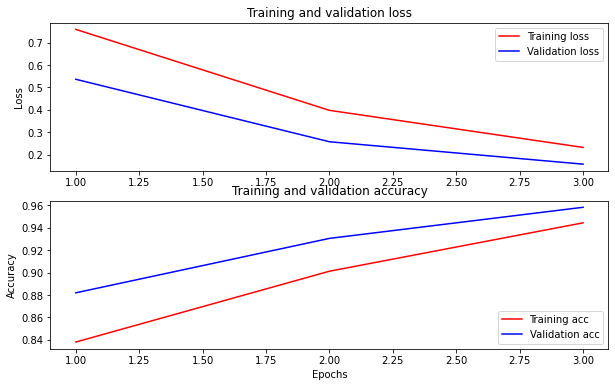

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
loss, accuracy = model.evaluate(val_ds)

print("Loss: ", loss)
print("Accuracy: {:2.2%}".format(accuracy))

36/36 [==============================] - 13s 346ms/step - loss: 0.1476 - accuracy: 0.9514
Loss:  0.14761614799499512
Accuracy: 95.14%


In [ ]:
y_predicted = model.predict(val_ds)
y_predicted = y_predicted.flatten()
print(y_predicted)

[9.8920983e-01 1.7114259e-04 1.3964456e-04 ... 4.0693337e-04 3.3829750e-03
 4.9724092e-04]


In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 0, ..., 0, 0, 0])